## 1.0 Imports

In [2]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imageio

import tensorflow.compat.v1 as tf
from tensorflow import keras

print("All imported!")

All imported!


In [3]:
# disabeling the eager execution
tf.disable_eager_execution()

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4205023527937718188,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14119419741752932833
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1536294912
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5618084258265327441
 physical_device_desc: "device: 0, name: GeForce MX130, pci bus id: 0000:01:00.0, compute capability: 5.0",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3428215332206279107
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.2.0


## 1.1 Loading the dataset in NPY format

In [7]:
# loading the data
file_path = "/home/ricky/Desktop/Face Generation/data/preprocessed_data/celebrity_faces.npy"
X = np.load(file_path)

In [8]:
print(X.shape)

(60000, 64, 64, 3)


## 1.2 Network Hyperparameters

In [8]:
image_height = 64
image_width = 64
image_channels = 3

noise_dim = 100
gen_learning_rate = 0.0002
disc_learning_rate = 0.0002
beta_1 = 0.5

BATCH_SIZE = 128
epochs = 150

## 1.3 Building the Data Generator

In [9]:
def FaceDataGen(data, batch_size = BATCH_SIZE):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=(1.0 / 255.0))
    datagen.fit(data)
    gen = datagen.flow(data, batch_size= batch_size, shuffle=True)
    while True:
        batch = gen.next()
        yield batch

In [10]:
# building the generator which will tield a tensor of shape [Batch size, 64, 64, 3]
datagen = FaceDataGen(data = X)

## 2.0 Building the Deep Convolution Generative Adversarial Model

### 2.1 The Generator Model

In [11]:
def generator(noise, reuse = None):
       
  """
  A 100 dimensional uniform distribution Z is projected to a small spatial extent convolutional representation with many feature maps.
  A series of four fractionally-strided convolutions (in some recent papers, these are wrongly called
  deconvolutions) then convert this high level representation into a 64 × 64 pixel image. 
  """

  with tf.variable_scope("generator_model", reuse=reuse):

    weight_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    
    # shape = (BATCH_SIZE, 16384)
    hidden_1 = tf.layers.dense(inputs = noise,
                                units = 1024*4*4,
                                kernel_initializer = weight_init,
                                use_bias = False,
                                )
    hidden_1 = tf.layers.batch_normalization(hidden_1, axis = -1)
    hidden_1 = tf.nn.relu(hidden_1)

    #shape = (BATCH_SIZE, 4, 4, 1024)
    hidden_2 = tf.reshape(hidden_1, shape = [-1, 4, 4, 1024])

    # shape = (BATCH_SIZE, 8, 8, 512)
    hidden_3 = tf.layers.conv2d_transpose(inputs = hidden_2, 
                                          filters = 512,
                                          kernel_size = 5,
                                          strides = 2,
                                          kernel_initializer = weight_init,
                                          use_bias = False,
                                          padding = "same"
                                          )
    hidden_3 = tf.layers.batch_normalization(hidden_3, axis = -1)
    hidden_3 = tf.nn.relu(hidden_3)
    
    # shape = (BATCH_SIZE, 16, 16, 256)
    hidden_4 = tf.layers.conv2d_transpose(inputs = hidden_3, 
                                          filters = 256,
                                          kernel_size = 5,
                                          strides = 2,
                                          kernel_initializer = weight_init,
                                          use_bias = False,
                                          padding = "same",
                                          )
    hidden_4 = tf.layers.batch_normalization(hidden_4, axis = -1)
    hidden_4 = tf.nn.relu(hidden_4)
     
    # shape = (BATCH_SIZE, 32, 32, 128)
    hidden_5 = tf.layers.conv2d_transpose(inputs = hidden_4, 
                                          filters = 128,
                                          kernel_size = 5,
                                          strides = 2,
                                          kernel_initializer = weight_init,
                                          use_bias = False,
                                          padding = "same",
                                          )
    hidden_5 = tf.layers.batch_normalization(hidden_5, axis = -1)
    hidden_5 = tf.nn.relu(hidden_5)

    # shape = (BATCH_SIZE, 64, 64, 3)
    op =  tf.layers.conv2d_transpose(inputs = hidden_5, 
                                      filters = 3,
                                      kernel_size = 5,
                                      strides = 2,
                                      kernel_initializer = weight_init,
                                      use_bias = False,
                                      activation = tf.nn.tanh,
                                      padding = "same",
                                      )
    return op

### 2.2 The discriminator Model

In [12]:
def discriminator(image, reuse = None):
    
    """
    The discriminator tries to discriminate between the fake and generated image.
    """
    
    with tf.variable_scope("discriminator_model", reuse=reuse):

        weight_init =  tf.random_normal_initializer(mean=0.0, stddev=0.02)

        # shape = (BATCH_SIZE, 32, 32, 64)
        hidden_1 = tf.layers.conv2d(inputs = image, 
                                    filters = 64,
                                    kernel_size = 5,
                                    strides = 2,
                                    kernel_initializer = weight_init,
                                    use_bias = False,
                                    padding = "same")
        hidden_1 = tf.nn.leaky_relu(hidden_1, alpha = 0.2)

        # shape = (BATCH_SIZE, 16, 16, 128)
        hidden_2 = tf.layers.conv2d(inputs = hidden_1, 
                                    filters = 128,
                                    kernel_size = 5,
                                    strides = 2,
                                    kernel_initializer = weight_init,
                                    use_bias = False,
                                    padding = "same")
        hidden_2 = tf.layers.batch_normalization(hidden_2, axis = -1)
        hidden_2 = tf.nn.leaky_relu(hidden_2, alpha = 0.2)


        # shape = (BATCH_SIZE, 8, 8, 256)
        hidden_3 = tf.layers.conv2d(inputs = hidden_2, 
                                    filters = 256,
                                    kernel_size = 5,
                                    strides = 2,
                                    kernel_initializer = weight_init,
                                    use_bias = False,
                                    padding = "same")
        hidden_3 = tf.layers.batch_normalization(hidden_3, axis = -1)
        hidden_3 = tf.nn.leaky_relu(hidden_3, alpha = 0.2)

        # shape = (BATCH_SIZE, 4, 4, 512)
        hidden_4 = tf.layers.conv2d(inputs = hidden_3, 
                                    filters = 512,
                                    kernel_size = 5,
                                    strides = 2,
                                    kernel_initializer = weight_init,
                                    use_bias = False,
                                    padding = "same"
                                  )
        hidden_4 = tf.layers.batch_normalization(hidden_4, axis = -1)
        hidden_4 = tf.nn.leaky_relu(hidden_4, alpha = 0.2)

        # flattening
        flatten = tf.layers.flatten(hidden_4)

        # output layer, units = 1
        output = tf.layers.dense(flatten, units = 1, activation = tf.nn.sigmoid)

        return output

## 3.0 Placeholders

In [13]:
# building the network
tf.reset_default_graph()

# Noise and real data placeholder | Z = noise, X = real data
z = tf.placeholder(tf.float32, shape = [None, noise_dim])
x = tf.placeholder(tf.float32, shape = [None, image_height, image_width, image_channels])

In [14]:
# dataflow throught the GAN
with tf.name_scope("Generator") as scope:
    gen_sample = generator(noise = z)

with tf.name_scope("Discriminator") as scope:
    disc_real = discriminator(image = x)
    disc_fake = discriminator(gen_sample, reuse = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is depr

## 3.1 Building the Adversarial Loss Function

In [15]:
# Build Loss
with tf.name_scope("Generator_Loss") as scope:
    gen_loss = -tf.reduce_mean(tf.log(disc_fake + 0.00001))
  
with tf.name_scope("Discriminator_Loss") as scope:
    disc_loss = -tf.reduce_mean(tf.log(disc_real + 0.00001) + tf.log(1. - disc_fake + 0.00001))

## 3.2 Using Adam Optimizer for both Generator and Discriminator

In [16]:
# Build Optimizers
with tf.name_scope("Generator_optimizer") as scope:
    optimizer_gen = tf.train.AdamOptimizer(learning_rate=gen_learning_rate, beta1= beta_1)

with tf.name_scope("Discriminator_optimizer") as scope:
    optimizer_disc = tf.train.AdamOptimizer(learning_rate=disc_learning_rate, beta1 = beta_1)

In [17]:
# vars of generator and discriminator
vars = tf.trainable_variables()
gen_params = [var for var in vars if "generator_model" in var.name]
disc_params = [var for var in vars if "discriminator_model" in var.name]

# optimizers
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_params)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_params)

## 4.0 Training the Generator and discriminator

In [18]:
gen_loss_per_epoch, disc_loss_per_epoch = [], []
steps_per_epoch = X.shape[0] // BATCH_SIZE

saver = tf.train.Saver()
init = tf.global_variables_initializer()

images = []

In [19]:
# model saving path
saver_path = f"/home/ricky/Desktop/Face Generation/models/FaceGan_{epochs}epc"

Training started...
Epoch: 1, Generator Loss: 1.0295374393463135, Discriminator Loss: 1.2056347131729126


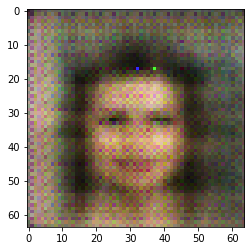



Epoch: 2, Generator Loss: 0.8889952898025513, Discriminator Loss: 1.2589318752288818


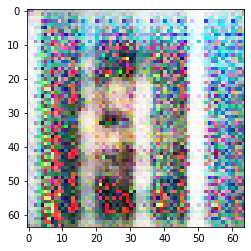



Epoch: 3, Generator Loss: 1.0406094789505005, Discriminator Loss: 1.139356017112732


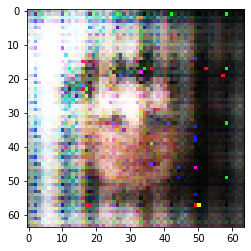



Epoch: 4, Generator Loss: 1.1277720928192139, Discriminator Loss: 1.1027133464813232


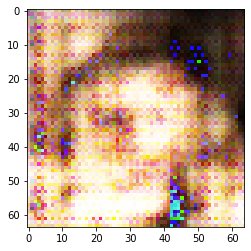



Epoch: 5, Generator Loss: 1.0829507112503052, Discriminator Loss: 1.1441264152526855


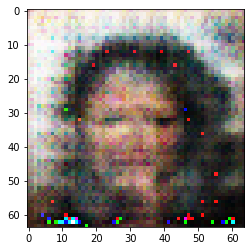



Epoch: 6, Generator Loss: 1.107891321182251, Discriminator Loss: 1.1198214292526245


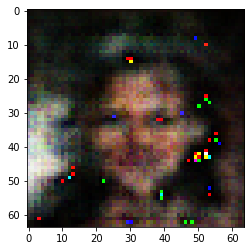



Epoch: 7, Generator Loss: 1.1956119537353516, Discriminator Loss: 1.069482684135437


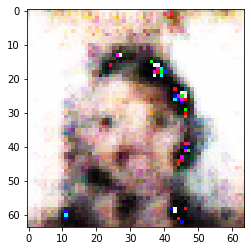



Epoch: 8, Generator Loss: 1.2098792791366577, Discriminator Loss: 1.0902099609375


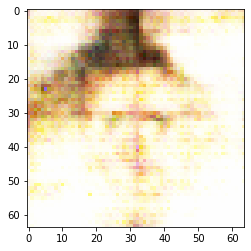



Epoch: 9, Generator Loss: 1.2683351039886475, Discriminator Loss: 1.0506799221038818


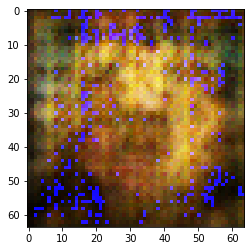



Epoch: 10, Generator Loss: 1.3350696563720703, Discriminator Loss: 1.0221261978149414


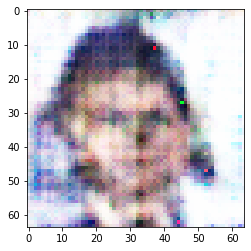



Epoch: 11, Generator Loss: 1.352141261100769, Discriminator Loss: 1.0106183290481567


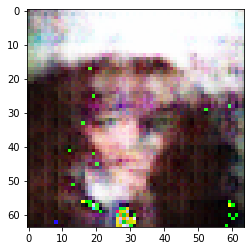



Epoch: 12, Generator Loss: 1.2763001918792725, Discriminator Loss: 1.073761224746704


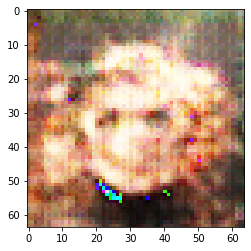



Epoch: 13, Generator Loss: 1.3202025890350342, Discriminator Loss: 1.0288878679275513


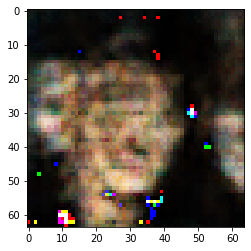



Epoch: 14, Generator Loss: 1.2546261548995972, Discriminator Loss: 1.0479453802108765


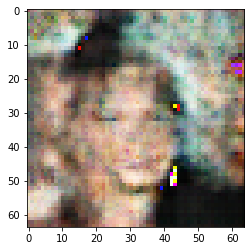



Epoch: 15, Generator Loss: 1.2203402519226074, Discriminator Loss: 1.0668171644210815


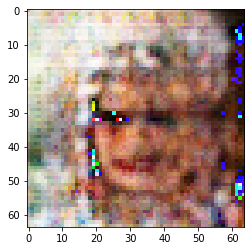



Epoch: 16, Generator Loss: 1.0527960062026978, Discriminator Loss: 1.1580698490142822


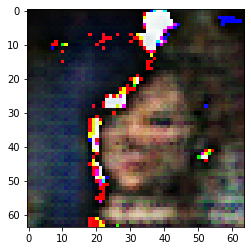



Epoch: 17, Generator Loss: 1.115074634552002, Discriminator Loss: 1.1425715684890747


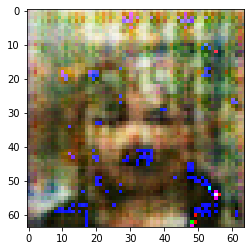



Epoch: 18, Generator Loss: 1.1331082582473755, Discriminator Loss: 1.1049906015396118


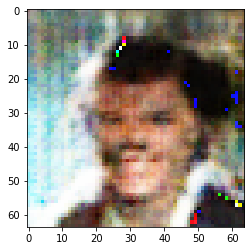



Epoch: 19, Generator Loss: 1.1878607273101807, Discriminator Loss: 1.1039994955062866


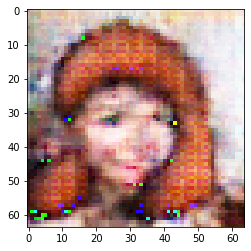



Epoch: 20, Generator Loss: 1.2043529748916626, Discriminator Loss: 1.0767524242401123


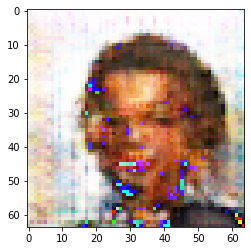



Epoch: 21, Generator Loss: 1.1804934740066528, Discriminator Loss: 1.128257393836975


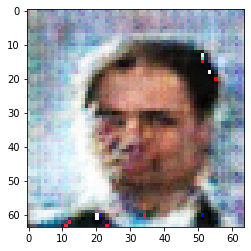



Epoch: 22, Generator Loss: 1.1928786039352417, Discriminator Loss: 1.0854897499084473


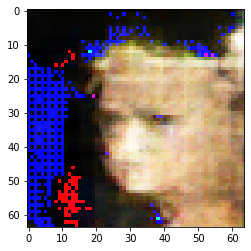



Epoch: 23, Generator Loss: 1.198670744895935, Discriminator Loss: 1.1010878086090088


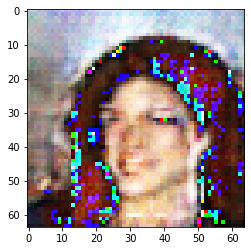



Epoch: 24, Generator Loss: 1.2129507064819336, Discriminator Loss: 1.101213812828064


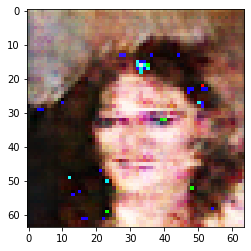



Epoch: 25, Generator Loss: 1.194202184677124, Discriminator Loss: 1.0795783996582031


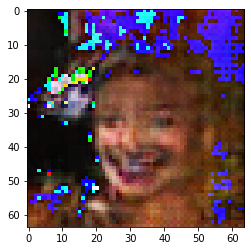



Epoch: 26, Generator Loss: 1.1798064708709717, Discriminator Loss: 1.0843744277954102


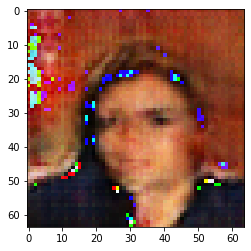



Epoch: 27, Generator Loss: 1.2093780040740967, Discriminator Loss: 1.079148769378662


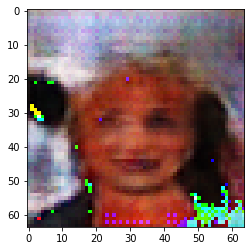



Epoch: 28, Generator Loss: 1.194336175918579, Discriminator Loss: 1.1151584386825562


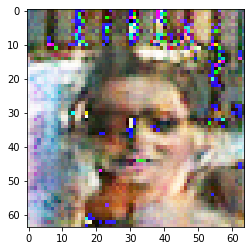



Epoch: 29, Generator Loss: 1.1744678020477295, Discriminator Loss: 1.0920647382736206


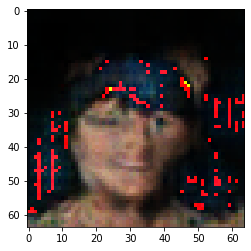



Epoch: 30, Generator Loss: 1.1945102214813232, Discriminator Loss: 1.10303795337677


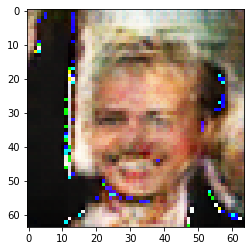



Epoch: 31, Generator Loss: 1.1609896421432495, Discriminator Loss: 1.1116818189620972


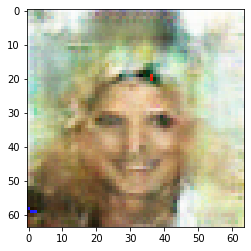



Epoch: 32, Generator Loss: 1.1761327981948853, Discriminator Loss: 1.1036839485168457


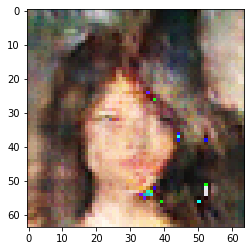



Epoch: 33, Generator Loss: 1.2112523317337036, Discriminator Loss: 1.0683091878890991


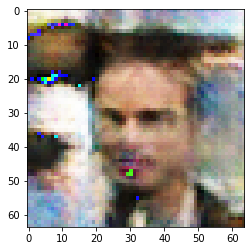



Epoch: 34, Generator Loss: 1.1772676706314087, Discriminator Loss: 1.085775375366211


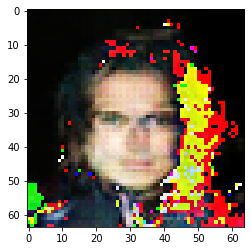



Epoch: 35, Generator Loss: 1.1794517040252686, Discriminator Loss: 1.1018925905227661


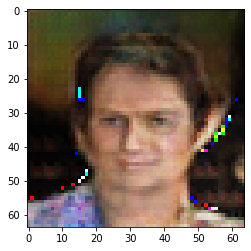



Epoch: 36, Generator Loss: 1.1932042837142944, Discriminator Loss: 1.0895479917526245


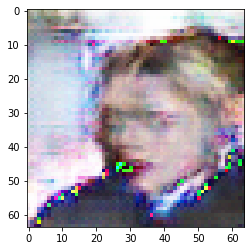



Epoch: 37, Generator Loss: 1.1599085330963135, Discriminator Loss: 1.113243818283081


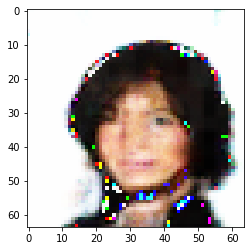



Epoch: 38, Generator Loss: 1.1893750429153442, Discriminator Loss: 1.0846073627471924


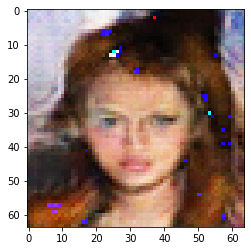



Epoch: 39, Generator Loss: 1.1583011150360107, Discriminator Loss: 1.1107124090194702


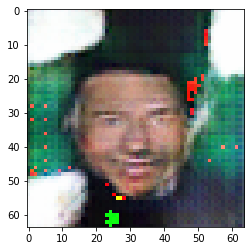



Epoch: 40, Generator Loss: 1.1426889896392822, Discriminator Loss: 1.099747896194458


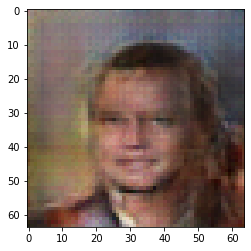



Epoch: 41, Generator Loss: 1.1462997198104858, Discriminator Loss: 1.1114311218261719


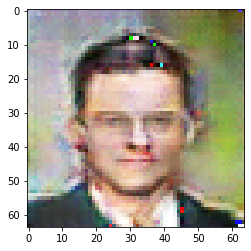



Epoch: 42, Generator Loss: 1.1208182573318481, Discriminator Loss: 1.1434394121170044


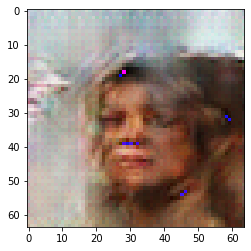



Epoch: 43, Generator Loss: 1.1106928586959839, Discriminator Loss: 1.1313555240631104


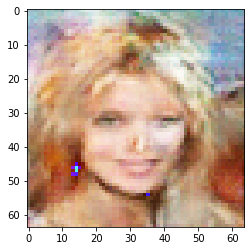



Epoch: 44, Generator Loss: 1.1094321012496948, Discriminator Loss: 1.1451269388198853


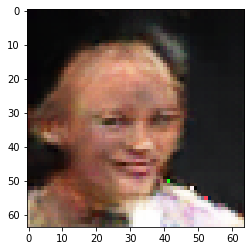



Epoch: 45, Generator Loss: 1.137265920639038, Discriminator Loss: 1.1302727460861206


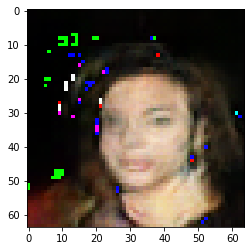



Epoch: 46, Generator Loss: 1.0962163209915161, Discriminator Loss: 1.1400378942489624


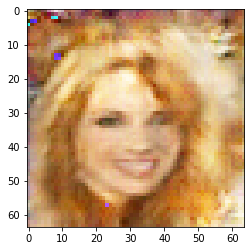



Epoch: 47, Generator Loss: 1.096087098121643, Discriminator Loss: 1.143342137336731


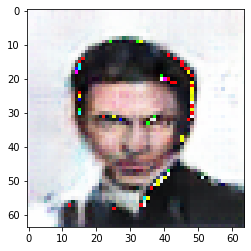



Epoch: 48, Generator Loss: 1.1194517612457275, Discriminator Loss: 1.1340456008911133


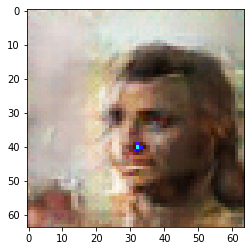



Epoch: 49, Generator Loss: 1.116589903831482, Discriminator Loss: 1.1441755294799805


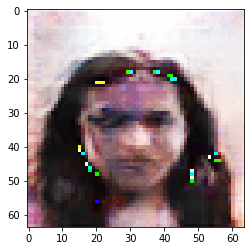



Epoch: 50, Generator Loss: 1.1181644201278687, Discriminator Loss: 1.1358720064163208


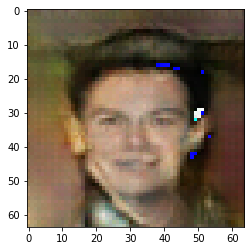



Epoch: 51, Generator Loss: 1.1378103494644165, Discriminator Loss: 1.1326072216033936


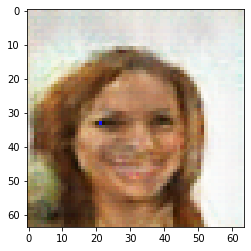



Epoch: 52, Generator Loss: 1.1449657678604126, Discriminator Loss: 1.130873441696167


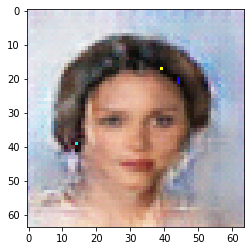



Epoch: 53, Generator Loss: 1.1445424556732178, Discriminator Loss: 1.1117610931396484


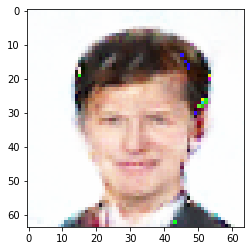



Epoch: 54, Generator Loss: 1.1171938180923462, Discriminator Loss: 1.1486985683441162


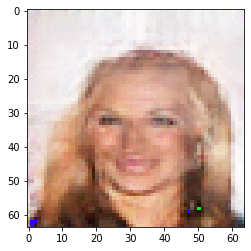



Epoch: 55, Generator Loss: 1.1854702234268188, Discriminator Loss: 1.0918546915054321


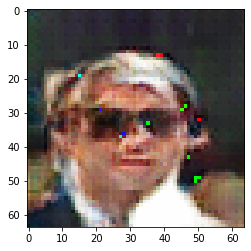



Epoch: 56, Generator Loss: 1.1857727766036987, Discriminator Loss: 1.0997556447982788


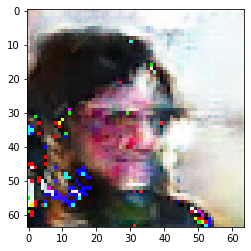



Epoch: 57, Generator Loss: 1.1810024976730347, Discriminator Loss: 1.104759693145752


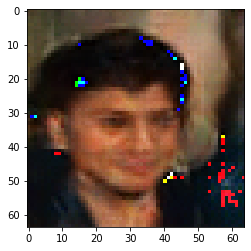



Epoch: 58, Generator Loss: 1.1498955488204956, Discriminator Loss: 1.1146223545074463


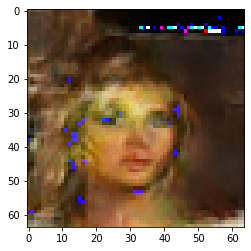



Epoch: 59, Generator Loss: 1.1901562213897705, Discriminator Loss: 1.075975775718689


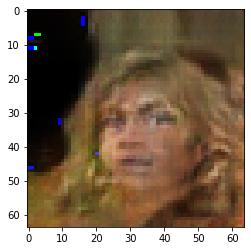



Epoch: 60, Generator Loss: 1.2254159450531006, Discriminator Loss: 1.0655276775360107


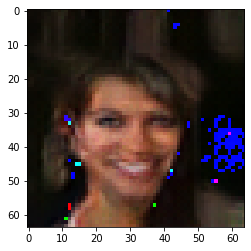



Epoch: 61, Generator Loss: 1.2149767875671387, Discriminator Loss: 1.0625061988830566


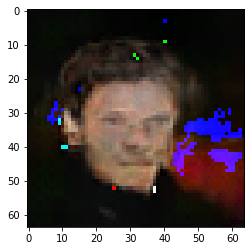



Epoch: 62, Generator Loss: 1.2284281253814697, Discriminator Loss: 1.0593069791793823


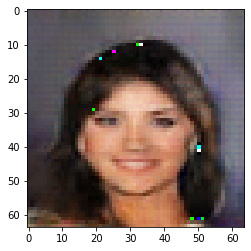



Epoch: 63, Generator Loss: 1.2407951354980469, Discriminator Loss: 1.0417732000350952


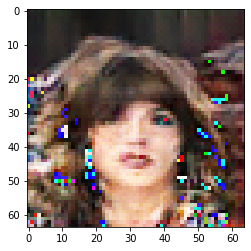



Epoch: 64, Generator Loss: 1.25778329372406, Discriminator Loss: 1.0434932708740234


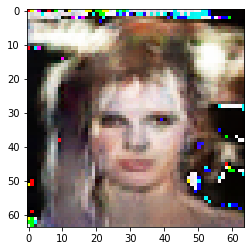



Epoch: 65, Generator Loss: 1.299407958984375, Discriminator Loss: 1.020365834236145


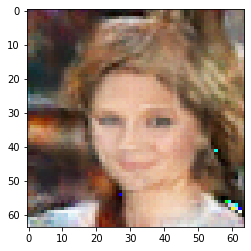



Epoch: 66, Generator Loss: 1.294466495513916, Discriminator Loss: 1.0175411701202393


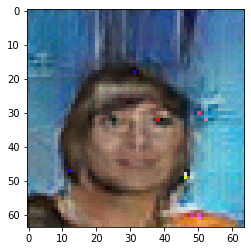



Epoch: 67, Generator Loss: 1.330945611000061, Discriminator Loss: 1.001893162727356


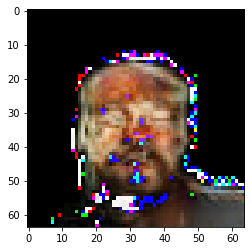



Epoch: 68, Generator Loss: 1.3310307264328003, Discriminator Loss: 0.987611711025238


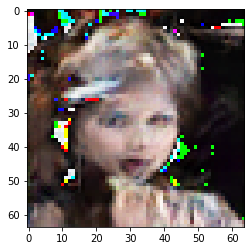



Epoch: 69, Generator Loss: 1.343398928642273, Discriminator Loss: 0.9884868264198303


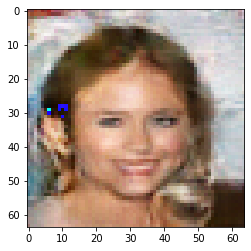



Epoch: 70, Generator Loss: 1.3613083362579346, Discriminator Loss: 0.9607306718826294


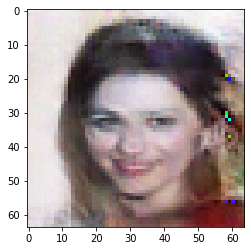



Epoch: 71, Generator Loss: 1.3832664489746094, Discriminator Loss: 0.9577584266662598


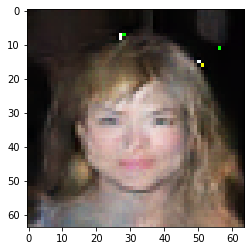



Epoch: 72, Generator Loss: 1.4049547910690308, Discriminator Loss: 0.9567092657089233


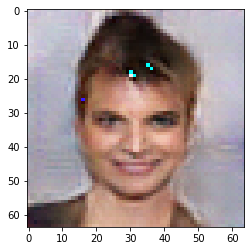



Epoch: 73, Generator Loss: 1.404343843460083, Discriminator Loss: 0.9797101020812988


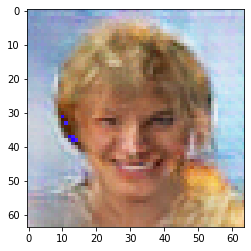



Epoch: 74, Generator Loss: 1.4221396446228027, Discriminator Loss: 0.9313499331474304


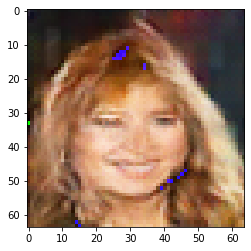



Epoch: 75, Generator Loss: 1.4458532333374023, Discriminator Loss: 0.9193571209907532


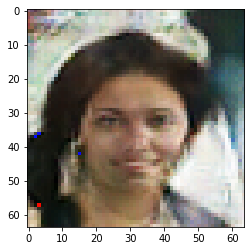



Epoch: 76, Generator Loss: 1.4948041439056396, Discriminator Loss: 0.9086028337478638


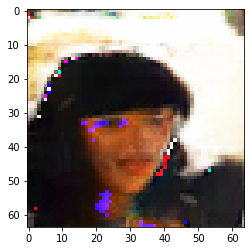



Epoch: 77, Generator Loss: 1.4889557361602783, Discriminator Loss: 0.9105575680732727


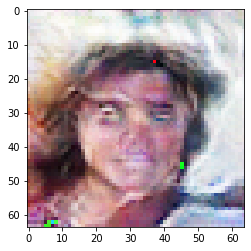



Epoch: 78, Generator Loss: 1.5116257667541504, Discriminator Loss: 0.8788298964500427


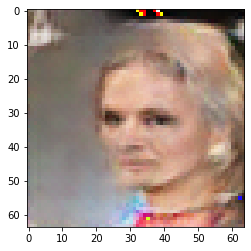



Epoch: 79, Generator Loss: 1.5520328283309937, Discriminator Loss: 0.9091454744338989


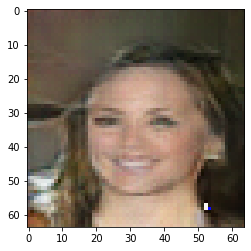



Epoch: 80, Generator Loss: 1.547156572341919, Discriminator Loss: 0.8655850291252136


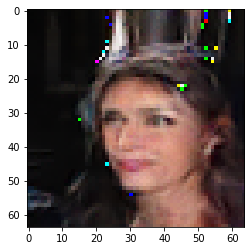



Epoch: 81, Generator Loss: 1.615687608718872, Discriminator Loss: 0.8612759113311768


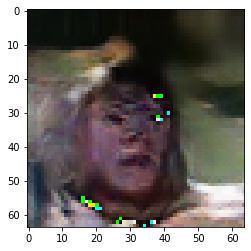



Epoch: 82, Generator Loss: 1.614679217338562, Discriminator Loss: 0.8380542993545532


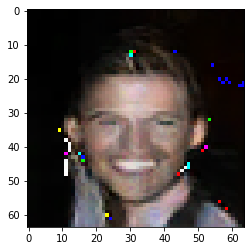



Epoch: 83, Generator Loss: 1.635835886001587, Discriminator Loss: 0.8310072422027588


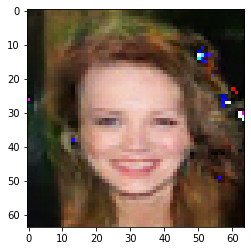



Epoch: 84, Generator Loss: 1.668154001235962, Discriminator Loss: 0.8350009322166443


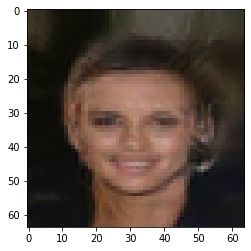



Epoch: 85, Generator Loss: 1.709791898727417, Discriminator Loss: 0.8100899457931519


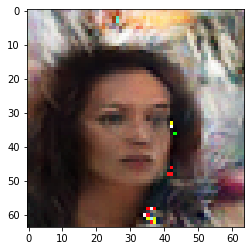



Epoch: 86, Generator Loss: 1.7370814085006714, Discriminator Loss: 0.7934115529060364


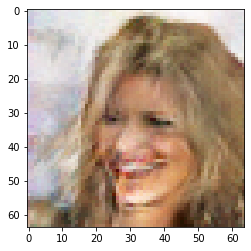



Epoch: 87, Generator Loss: 1.785352349281311, Discriminator Loss: 0.7816972732543945


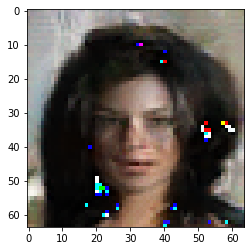



Epoch: 88, Generator Loss: 1.802354097366333, Discriminator Loss: 0.7599702477455139


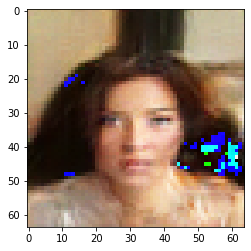



Epoch: 89, Generator Loss: 1.8287127017974854, Discriminator Loss: 0.7553549408912659


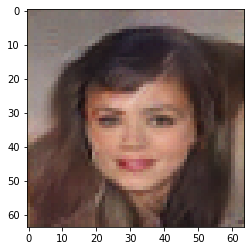



Epoch: 90, Generator Loss: 1.8844163417816162, Discriminator Loss: 0.7520365118980408


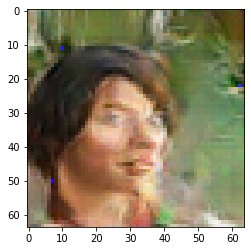



Epoch: 91, Generator Loss: 1.8956913948059082, Discriminator Loss: 0.7305425405502319


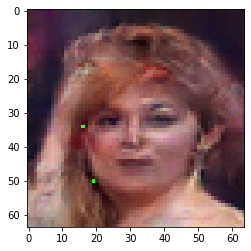



Epoch: 92, Generator Loss: 1.926727294921875, Discriminator Loss: 0.7239835262298584


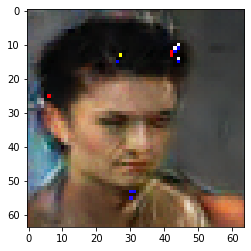



Epoch: 93, Generator Loss: 1.9613913297653198, Discriminator Loss: 0.7201704978942871


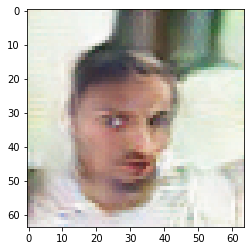



Epoch: 94, Generator Loss: 1.995784044265747, Discriminator Loss: 0.7174378633499146


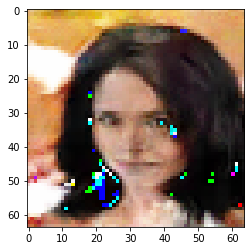



Epoch: 95, Generator Loss: 2.0343174934387207, Discriminator Loss: 0.6828082203865051


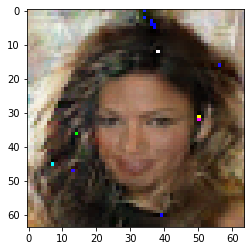



Epoch: 96, Generator Loss: 2.065277576446533, Discriminator Loss: 0.6780511736869812


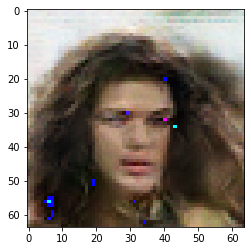



Epoch: 97, Generator Loss: 2.101167678833008, Discriminator Loss: 0.6664922833442688


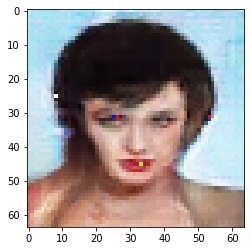



Epoch: 98, Generator Loss: 2.1616601943969727, Discriminator Loss: 0.6473027467727661


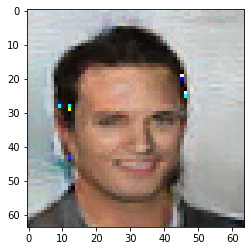



Epoch: 99, Generator Loss: 1.9462945461273193, Discriminator Loss: 2.3602795600891113


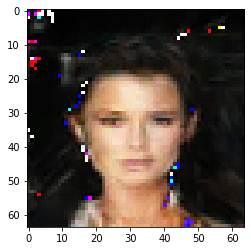



Epoch: 100, Generator Loss: 2.1348063945770264, Discriminator Loss: 0.6275949478149414


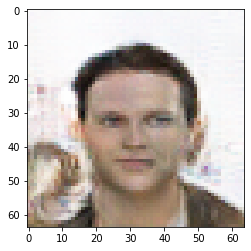



Epoch: 101, Generator Loss: 2.240738868713379, Discriminator Loss: 0.6034873127937317


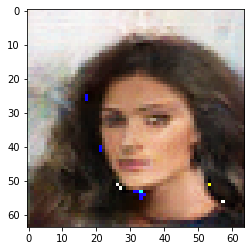



Epoch: 102, Generator Loss: 2.271542549133301, Discriminator Loss: 0.613945722579956


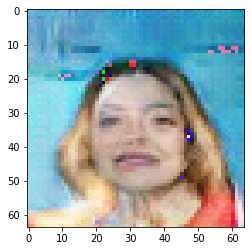



Epoch: 103, Generator Loss: 2.3350119590759277, Discriminator Loss: 0.5988290905952454


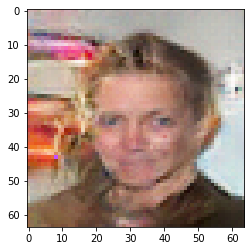



Epoch: 104, Generator Loss: 2.372549295425415, Discriminator Loss: 0.5908154845237732


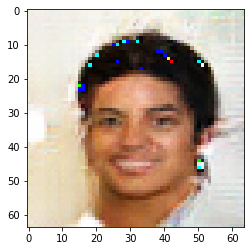



Epoch: 105, Generator Loss: 2.4193787574768066, Discriminator Loss: 0.5787444114685059


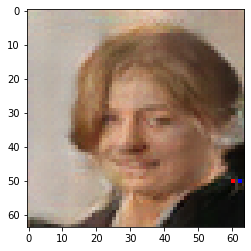



Epoch: 106, Generator Loss: 2.4918694496154785, Discriminator Loss: 0.5443378686904907


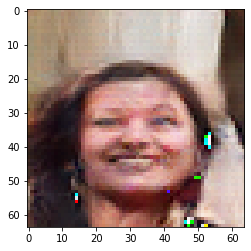



Epoch: 107, Generator Loss: 2.5431766510009766, Discriminator Loss: 0.554501473903656


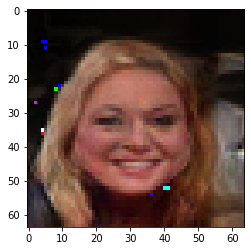



Epoch: 108, Generator Loss: 2.602360725402832, Discriminator Loss: 0.5199921727180481


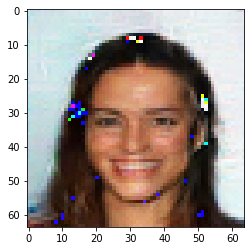



Epoch: 109, Generator Loss: 1.80495285987854, Discriminator Loss: 3.970655679702759


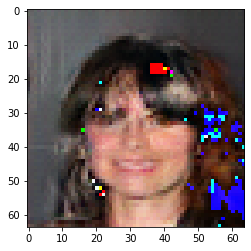



Epoch: 110, Generator Loss: 2.5537188053131104, Discriminator Loss: 0.5378983616828918


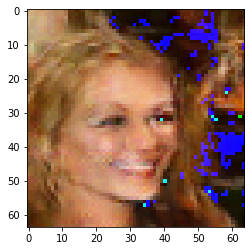



Epoch: 111, Generator Loss: 2.6603634357452393, Discriminator Loss: 0.49592751264572144


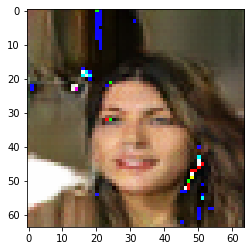



Epoch: 112, Generator Loss: 2.7456278800964355, Discriminator Loss: 0.49321794509887695


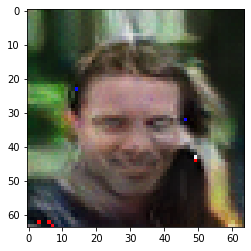



Epoch: 113, Generator Loss: 2.8071630001068115, Discriminator Loss: 0.48125791549682617


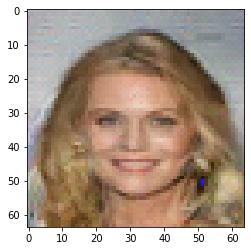



Epoch: 114, Generator Loss: 2.8630874156951904, Discriminator Loss: 0.4811227321624756


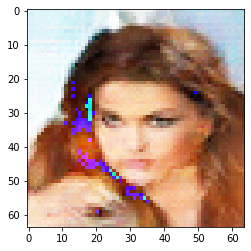



Epoch: 115, Generator Loss: 2.9325592517852783, Discriminator Loss: 0.4792168140411377


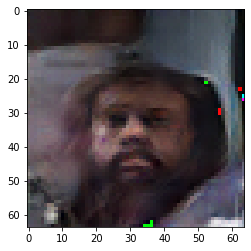



Epoch: 116, Generator Loss: 2.991555690765381, Discriminator Loss: 0.44632309675216675


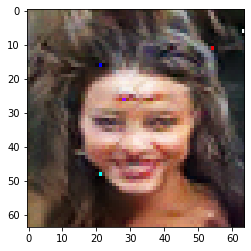



Epoch: 117, Generator Loss: 2.9522016048431396, Discriminator Loss: 0.5455737709999084


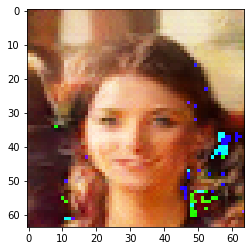



Epoch: 118, Generator Loss: 3.065152168273926, Discriminator Loss: 0.42779746651649475


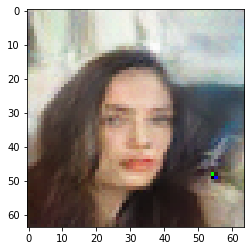



Epoch: 119, Generator Loss: 3.1560256481170654, Discriminator Loss: 0.4262371361255646


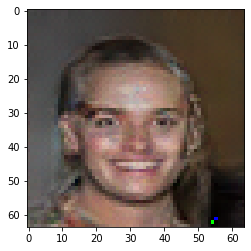



Epoch: 120, Generator Loss: 3.2143797874450684, Discriminator Loss: 0.42829790711402893


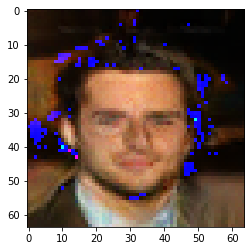



Epoch: 121, Generator Loss: 3.2550675868988037, Discriminator Loss: 0.4156878888607025


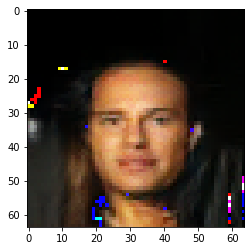



Epoch: 122, Generator Loss: 3.305483102798462, Discriminator Loss: 0.41602057218551636


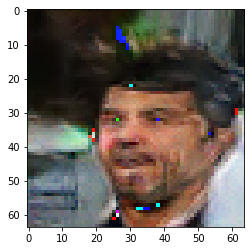



Epoch: 123, Generator Loss: 3.397106647491455, Discriminator Loss: 0.3857745826244354


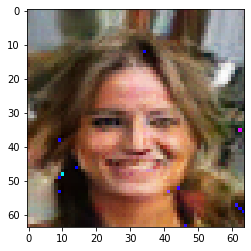



Epoch: 124, Generator Loss: 3.406656265258789, Discriminator Loss: 0.43018242716789246


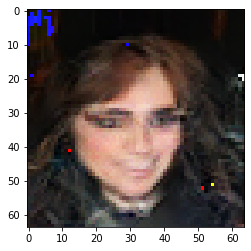



Epoch: 125, Generator Loss: 3.4847469329833984, Discriminator Loss: 0.36958324909210205


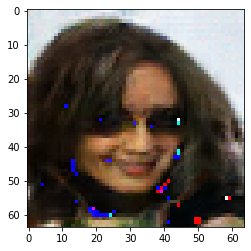



Epoch: 126, Generator Loss: 3.55029559135437, Discriminator Loss: 0.3827311098575592


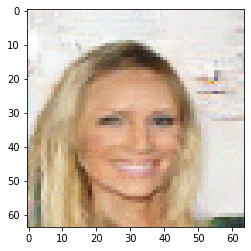



Epoch: 127, Generator Loss: 3.5630245208740234, Discriminator Loss: 0.38001227378845215


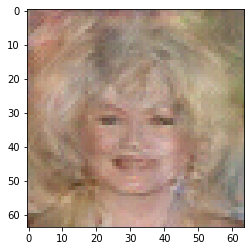



Epoch: 128, Generator Loss: 3.637366771697998, Discriminator Loss: 0.37035229802131653


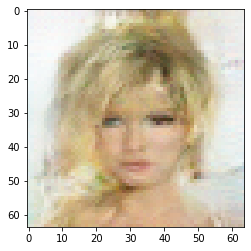



Epoch: 129, Generator Loss: 3.712675094604492, Discriminator Loss: 0.35327091813087463


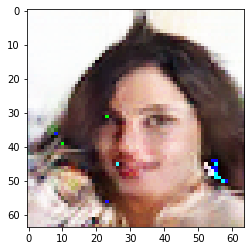



Epoch: 130, Generator Loss: 3.7825286388397217, Discriminator Loss: 0.341413289308548


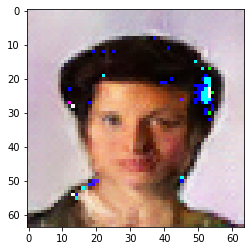



Epoch: 131, Generator Loss: 3.858971118927002, Discriminator Loss: 0.3353455364704132


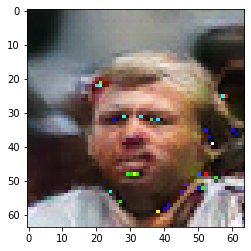



Epoch: 132, Generator Loss: 3.8727047443389893, Discriminator Loss: 0.3443112373352051


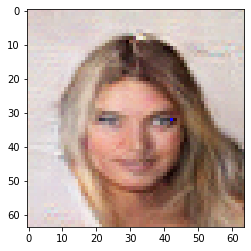



Epoch: 133, Generator Loss: 3.9656660556793213, Discriminator Loss: 0.32794496417045593


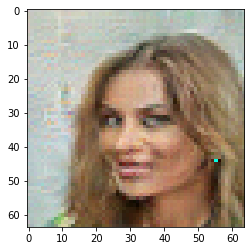



Epoch: 134, Generator Loss: 3.9921679496765137, Discriminator Loss: 0.3382922410964966


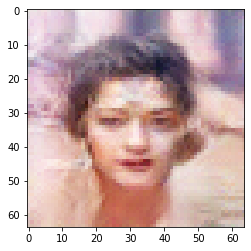



Epoch: 135, Generator Loss: 4.070790767669678, Discriminator Loss: 0.3075762987136841


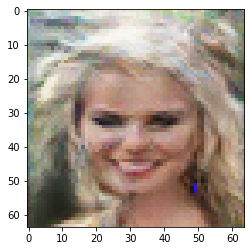



Epoch: 136, Generator Loss: 3.9936556816101074, Discriminator Loss: 0.41207560896873474


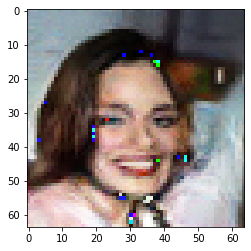



Epoch: 137, Generator Loss: 4.163849830627441, Discriminator Loss: 0.29520392417907715


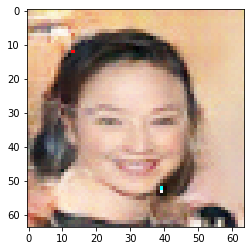



Epoch: 138, Generator Loss: 4.197851657867432, Discriminator Loss: 0.31580495834350586


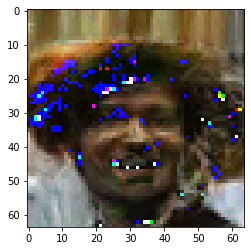



Epoch: 139, Generator Loss: 4.223010063171387, Discriminator Loss: 0.3197934329509735


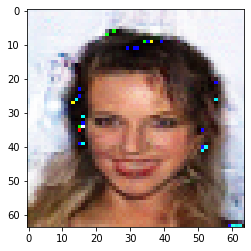



Epoch: 140, Generator Loss: 4.282924652099609, Discriminator Loss: 0.28785189986228943


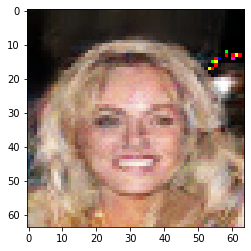



Epoch: 141, Generator Loss: 4.349167823791504, Discriminator Loss: 0.2961222231388092


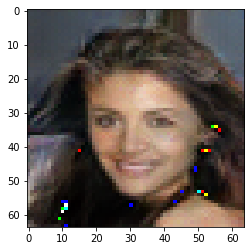



Epoch: 142, Generator Loss: 4.3848652839660645, Discriminator Loss: 0.29671573638916016


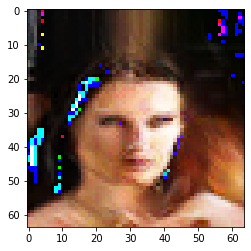



Epoch: 143, Generator Loss: 4.461581230163574, Discriminator Loss: 0.27650588750839233


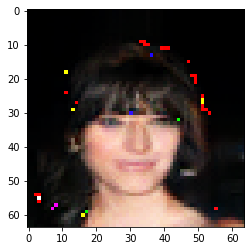



Epoch: 144, Generator Loss: 4.501418113708496, Discriminator Loss: 0.30960842967033386


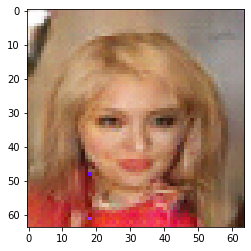



Epoch: 145, Generator Loss: 4.46899938583374, Discriminator Loss: 0.3180629312992096


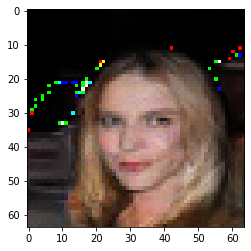



Epoch: 146, Generator Loss: 4.5820698738098145, Discriminator Loss: 0.2470887154340744


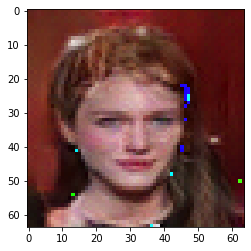



Epoch: 147, Generator Loss: 4.6307806968688965, Discriminator Loss: 0.2903710901737213


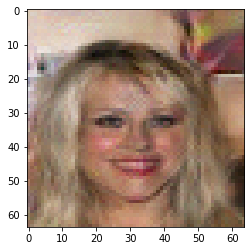



Epoch: 148, Generator Loss: 4.667614459991455, Discriminator Loss: 0.2562876045703888


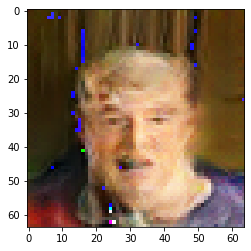



Epoch: 149, Generator Loss: 4.536940574645996, Discriminator Loss: 0.40288394689559937


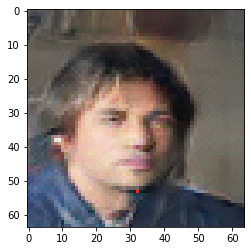



Epoch: 150, Generator Loss: 4.74414587020874, Discriminator Loss: 0.23415687680244446


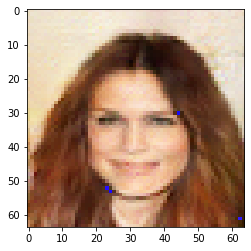

In [20]:
with tf.Session() as sess:
    sess.run(init)
    print("Training started...")
    for epc in range(1, epochs+1):
    generator_loss, discriminator_loss = [], []
    step = 0
    for x_batch in datagen:
        noise = np.random.uniform(low = -1.0, high = 1.0, size = (x_batch.shape[0], noise_dim))
        _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss], 
                                          feed_dict = {x : x_batch, z : noise})
        generator_loss.append(gl)
        discriminator_loss.append(dl)
        step += 1
        if step == steps_per_epoch:
        break

    # Loss calculation per epoch
    g_loss, d_loss = np.mean(generator_loss), np.mean(discriminator_loss)
    gen_loss_per_epoch.append(g_loss)
    disc_loss_per_epoch.append(d_loss)
    print(f"Epoch: {epc}, Generator Loss: {g_loss}, Discriminator Loss: {d_loss}")

    # sampling an image from the generator
    noise_vector = np.random.uniform(low = -1.0, high = 1.0, size = (1, noise_dim))
    generated_image = sess.run(gen_sample,
                               feed_dict = {z : noise_vector}).reshape(image_height, image_width, image_channels)
    # storing it into a dictionary
    sampled_face = (generated_image * 255).astype(np.uint8)
    images.append(sampled_face)
    plt.imshow(sampled_face)
    plt.show()
    print("\n")
    # saving the graph
    saver.save(sess, saver_path)

In [21]:
# saving the GIF
gif_save_path = r"/home/ricky/Desktop/Face Generation/GIF/FaceGan.gif"
imageio.mimsave(gif_save_path, images)

## 4.1 Plotting the generator and discriminator loss

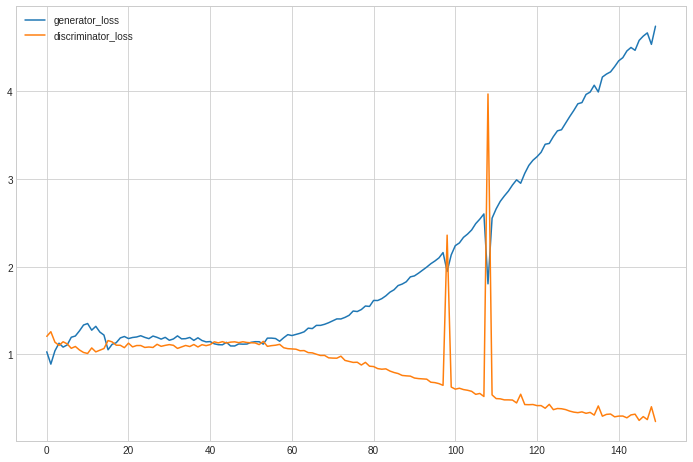

In [22]:
# plotting the generator loss and discriminator loss
plt.figure(figsize = (12, 8))
plt.style.use('seaborn-whitegrid')

plt.plot(gen_loss_per_epoch, label = "generator_loss");
plt.plot(disc_loss_per_epoch, label = "discriminator_loss");
plt.legend();
plt.show();